In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
road = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/aon_pathfinder'.format(scen=scenario))
distribution = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/distribution'.format(scen=scenario))
sm = road.copy()
sm.volumes = distribution.volumes

volumes: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [5]:
# each link can have its own capacity
sm.road_links['capacity'] = 1000

# 'volume_car' is used for road pathfinder
sm.volumes['volume_car'] = sm.volumes['car_owner']
sm.road_links
constrained = sm.copy()
free = sm.copy()

In [6]:
constrained.step_road_pathfinder(maxiters=100, log=True, tolerance=0.1)

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1703 94.943
1 0.1672 87.557
2 0.1609 72.871
3 0.125 52.132
4 0.1141 36.185
5 0.1078 23.399
6 0.0844 16.001
7 0.0969 11.449
8 0.0938 8.412
9 0.1328 6.409
10 0.2188 4.761
11 0.3672 3.285
12 0.6672 1.855
13 0.8 0.634
14 0.8 0.147
15 0.0359 2.46
16 0.0563 1.27
17 0.0609 1.176
18 0.0953 1.067
19 0.1125 0.786
20 0.0922 0.705
21 0.2188 0.519
22 0.2266 0.527
23 0.2109 0.344
24 0.3625 0.229
25 0.6656 0.144
26 0.8 0.051


In [7]:
constrained.car_los.head(2)

,origin,destination,time,path,gtime,node_path,link_path,ntlegs
0,zone_0,zone_0,0.000000,[zone_0],0.000000,[],[],[]
1,zone_0,zone_1,843.391757,"[zone_0, 15643099, 25554239, 25554240, 2555426...",843.391757,"[15643099, 25554239, 25554240, 25554265, 25554...","[1096, 2295, 2296, 2299, 2300, 14440]","[(zone_0, 15643099), (9074748722, zone_1)]"


In [8]:
constrained.road_links.head(2)

,index,a,b,length,geometry,time,walk_time,capacity,vdf,alpha,beta,limit,penalty,flow,jam_time,jam_speed
2,2,125743,244455500,38.764,"LINESTRING (268659.483 6250219.695, 268619.286...",6.929336,20.788008,1000,default_bpr,0.15,4,20,0,117.609601,6.929535,20.138494
3,3,125745,25245021,268.796,"LINESTRING (268764.391 6250213.130, 268749.819...",48.049165,144.147494,1000,default_bpr,0.15,4,20,0,385.951869,48.209087,20.072266


In [9]:
free.step_road_pathfinder(maxiters=1)

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0


In [10]:
free.road_links.head(2)

,index,a,b,length,geometry,time,walk_time,capacity,vdf,alpha,beta,limit,penalty,flow,jam_time,jam_speed
2,2,125743,244455500,38.764,"LINESTRING (268659.483 6250219.695, 268619.286...",6.929336,20.788008,1000,default_bpr,0.15,4,20,0,0.0,6.929336,20.139072
3,3,125745,25245021,268.796,"LINESTRING (268764.391 6250213.130, 268749.819...",48.049165,144.147494,1000,default_bpr,0.15,4,20,0,0.0,48.049165,20.139072


In [11]:
constrained.to_zippedpickles(training_folder + 'models/{scen}/constrained_road_pathfinder'.format(scen=scenario))

  0%|          | 0/33 [00:00<?, ?it/s]

relgap: 100%|██████████| 33/33 [00:02<00:00, 13.18it/s]                   


# PLOT

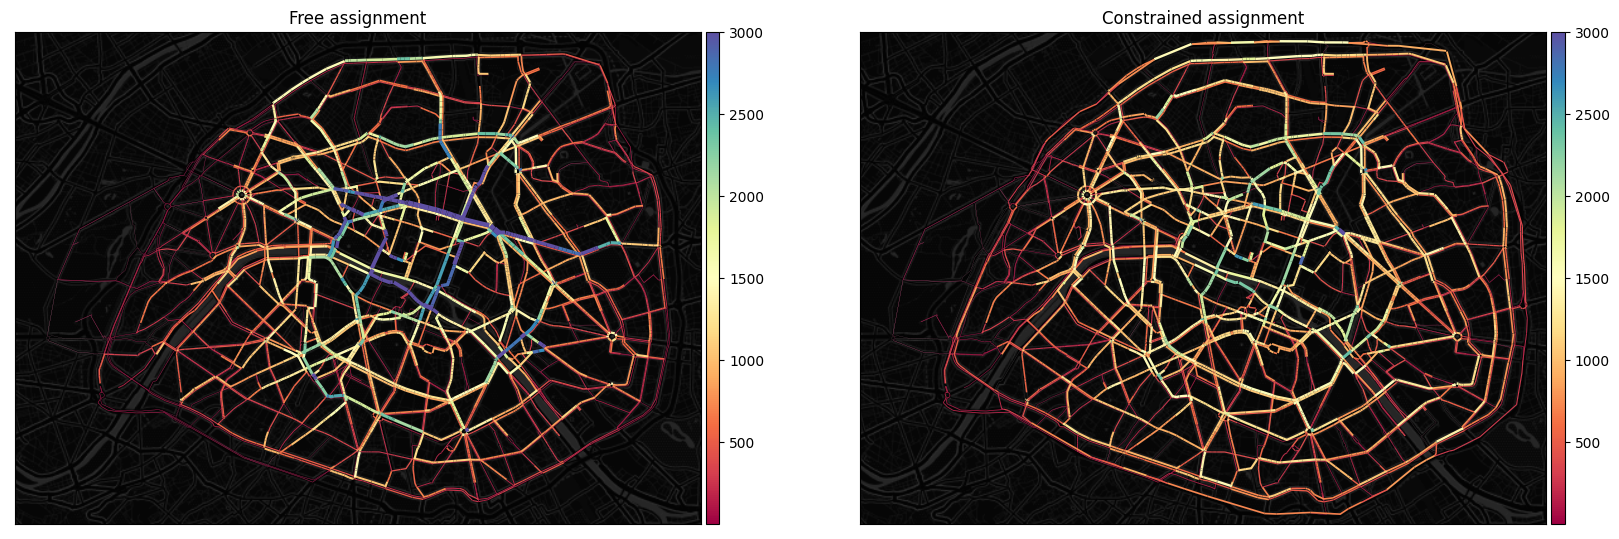

In [12]:
if manual:
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], ax=axes[0], max_value=3000
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")
    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], ax=axes[1], max_value=3000
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

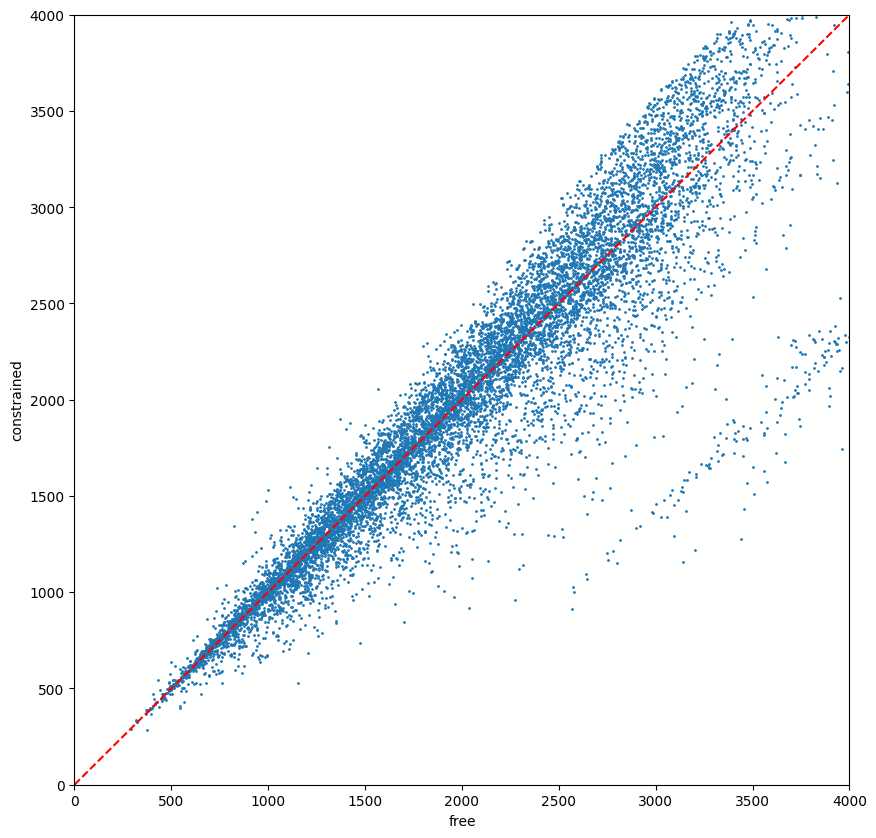

In [13]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['gtime'].min()
    f = free.car_los.groupby(['origin', 'destination'])['gtime'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)
    plt.plot([0, 4000], [0, 4000], color='red', linestyle='--')
    # square plot
    plt.xlim([0, 4000])
    plt.ylim([0, 4000])